
## Bilinear EfficientNet with Focal Loss + Label Smoothing
## Plant Pathology

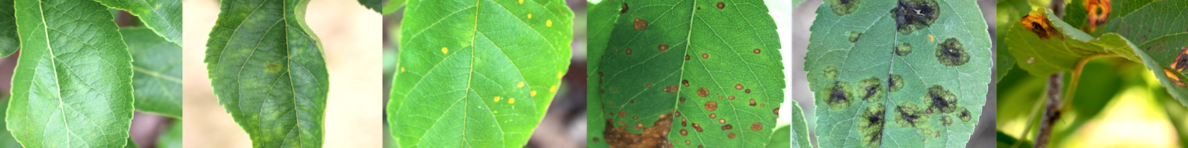

---
### **Problem Objectives:**    
#### The aim of this challenge is to build a Generalised Model for the task of Image Classification. We have to also deal with Class Imbalance Problem and detect Fine Grained details which differentiates whether the leaf is diseased or Not.  
 
### **Solution:**  
    i) Image Classification: EfficientNet

    ii) Class Imbalance and Generalization : Focal Loss + Label Smoothing

    iii) Detect Fine Grain Details: Bilinear CNN  
 ---
### Model: BiLinear EfficientNet with Focal Loss+ Label Smoothing 
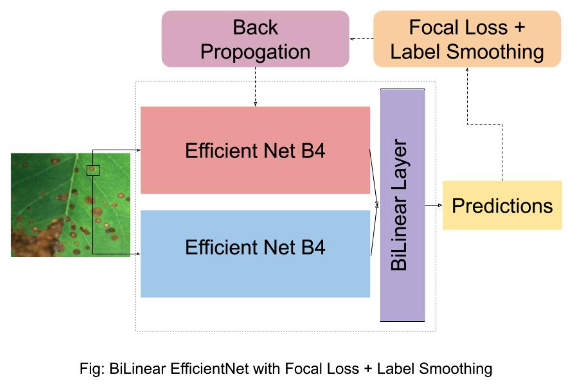

---
### **Expriments and Results:**  
    a) Selecting the Best and Efficient CNN Backbone (img size:380x380):
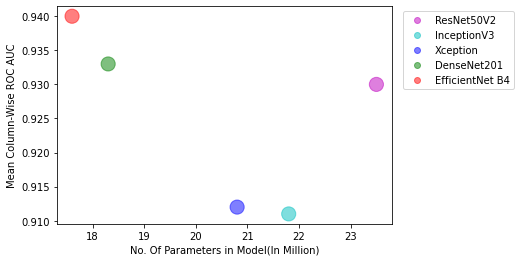

    b) Exprimenting with Loss Functions (img size:380x380):  
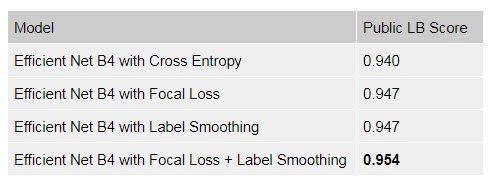

    c) Bilinear EffcientNet (img size:760x760):
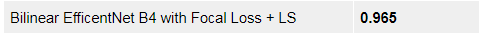
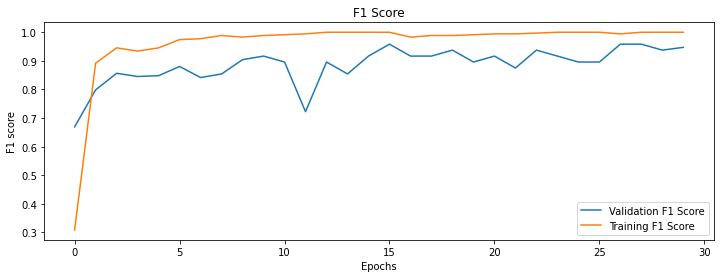    
 
---
**References:**  
[(1)   EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](http://https://arxiv.org/abs/1905.11946)  
[(2)   Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)  
[(3)   Bilinear CNNs for Fine-grained Visual Recognition](https://arxiv.org/abs/1504.07889)  
[(4)   Focal Loss Implementation](https://github.com/aldi-dimara/keras-focal-loss)  
[(5)   Label Smoothing Explaination and Formulas](https://towardsdatascience.com/what-is-label-smoothing-108debd7ef06)  
[(6)   BiLinear CNN Implementation](https://medium.com/@scorrea92/bilinear-cnn-models-in-tensorflow-keras-801121cc8c4d)  

---
   
**Contents of this Notebook**  
    1. Loading Dependencies and Dataset  
    2. Functions:  
        i. Bilinear Function  
        ii. Focal Loss + Label Smoothing   
        iii. F1 Score Metrics  
    3. Model  
    4. Training  
    5. Testing and Saving Model  
    

>  Note: The main purpose of this notebook is to implement the above mentioned Idea!


### 1. Loading Dependencies and Dataset 

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf, tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from kaggle_datasets import KaggleDatasets

In [ ]:
#TPU Configurations
AUTO = tf.data.experimental.AUTOTUNE
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

GCS_DS_PATH = KaggleDatasets().get_gcs_path()
print(GCS_DS_PATH)

In [ ]:
IMG_SIZE_h = 760 
IMG_SIZE_w = 760
BATCH_SIZE = 8*strategy.num_replicas_in_sync

In [ ]:
#Data Items
path='../input/plant-pathology-2020-fgvc7/'

train = pd.read_csv(path+'train.csv')
train_id = train['image_id']
train.pop('image_id')

y_train = train.to_numpy().astype('float32')
category_names = ['healthy','multiple_diseases','rust','scab']
root = 'images'

images_paths = [(os.path.join(GCS_DS_PATH,root,idee+'.jpg')) for idee in train_id]

In [ ]:
#Train Test Split
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(images_paths,y_train,test_size=0.198,shuffle=True) 

In [ ]:
def decode_image(filename, label=None, image_size=(IMG_SIZE_h, IMG_SIZE_w)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    #convert to numpy and do some cv2 staff mb?
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None, seed=5050):
    image = tf.image.random_flip_left_right(image, seed=seed)
    image = tf.image.random_flip_up_down(image, seed=seed)
    image = tf.image.random_crop(image,size=[IMG_SIZE_h,IMG_SIZE_w,3],seed=seed )
    image = tf.image.random_brightness(image,max_delta=0.5, seed=seed )
           
    if label is None:
        return image
    else:
        return image, label

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
    )

In [ ]:
val_dataset = (tf.data.Dataset
               .from_tensor_slices((x_val,y_val))
               .map(decode_image,num_parallel_calls=AUTO)
               .batch(BATCH_SIZE)
               .cache()
               .prefetch(AUTO)
              )

### 2. Functions

#### i)Focal Loss + Label Smoothing

In [ ]:
import keras.backend as K
import tensorflow as tf

def categorical_focal_loss_with_label_smoothing(gamma=2.0, alpha=0.25,ls=0.1,classes=4.0):
    """
    Implementation of Focal Loss from the paper in multiclass classification
    Formula:
        loss = -alpha*((1-p)^gamma)*log(p)
        y_ls = (1 - α) * y_hot + α / classes
    Parameters:
        alpha -- the same as wighting factor in balanced cross entropy
        gamma -- focusing parameter for modulating factor (1-p)
        ls    -- label smoothing parameter(alpha)
        classes     -- No. of classes
    Default value:
        gamma -- 2.0 as mentioned in the paper
        alpha -- 0.25 as mentioned in the paper
        ls    -- 0.1
        classes     -- 4
    """
    def focal_loss(y_true, y_pred):
        # Define epsilon so that the backpropagation will not result in NaN
        # for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        #y_pred = y_pred + epsilon
        #label smoothing
        y_pred_ls = (1 - ls) * y_pred + ls / classes
        # Clip the prediction value
        y_pred_ls = K.clip(y_pred_ls, epsilon, 1.0-epsilon)
        # Calculate cross entropy
        cross_entropy = -y_true*K.log(y_pred_ls)
        # Calculate weight that consists of  modulating factor and weighting factor
        weight = alpha * y_true * K.pow((1-y_pred_ls), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.sum(loss, axis=1)
        return loss
    
    return focal_loss

#### ii) BiLinear Layer (outer_product())

In [ ]:
import tensorflow as tf

def outer_product(x):
    #Einstein Notation  [batch,1,1,depth] x [batch,1,1,depth] -> [batch,depth,depth]
    phi_I = tf.einsum('ijkm,ijkn->imn',x[0],x[1])
    
    # Reshape from [batch_size,depth,depth] to [batch_size, depth*depth]
    phi_I = tf.reshape(phi_I,[-1,x[0].shape[3]*x[1].shape[3]])
    
    # Divide by feature map size [sizexsize]
    size1 = int(x[1].shape[1])
    size2 = int(x[1].shape[2])
    phi_I = tf.divide(phi_I, size1*size2)
    
    # Take signed square root of phi_I
    y_ssqrt = tf.multiply(tf.sign(phi_I),tf.sqrt(tf.abs(phi_I)+1e-12))
    
    # Apply l2 normalization
    z_l2 = tf.nn.l2_normalize(y_ssqrt, axis=1)
    return z_l2

#### iii)F1 Score

In [ ]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### 3. Model

In [ ]:
!pip install efficientnet

In [ ]:
import efficientnet.tfkeras as efn
import tensorflow as tf, tensorflow.keras.backend as K
from tensorflow.keras.layers import Convolution2D,Activation,MaxPooling2D,Flatten,Dense,Dropout,Input,Reshape,Lambda
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras import optimizers
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
def get_model():
    
    input_tensor = Input(shape=(IMG_SIZE_h,IMG_SIZE_w,3))
    
    model1 = efn.EfficientNetB4(weights='imagenet', include_top=False, input_tensor=input_tensor,input_shape=(IMG_SIZE_h, IMG_SIZE_w, 3))
    model2 = efn.EfficientNetB4(weights='noisy-student', include_top=False, input_tensor=input_tensor,input_shape=(IMG_SIZE_h, IMG_SIZE_w, 3))
    
    for i, layer in enumerate(model1.layers):
        layer._name = 'model1_' + layer.name

    last_layer1 = model1.get_layer('model1_top_conv')
    last_output1 = last_layer1.output

    for i, layer in enumerate(model2.layers):
        layer._name = 'model2_' + layer.name

    last_layer2 = model2.get_layer('model2_top_conv')
    last_output2 = last_layer2.output
    
    
    model1_ = Model(inputs=model1.input, outputs=last_output1)
    model2_ = Model(inputs=model2.input, outputs=last_output2)
   
    
    model1_.compile(Adam(lr=0.0003, decay=1e-3),loss=categorical_focal_loss_with_label_smoothing(gamma=2.0, alpha=0.75, ls=0.125, classes=4.0))
    model2_.compile(Adam(lr=0.0003, decay=1e-3),loss=categorical_focal_loss_with_label_smoothing(gamma=2.0, alpha=0.75, ls=0.125, classes=4.0))
    
    d1=model1_.output
    d2=model2_.output

    bilinear = Lambda(outer_product, name='outer_product1')([d1,d2])
    
    predictions=Dense(4, activation='softmax', name='predictions')(bilinear)
    model = Model(inputs=model1.input, outputs=predictions)

    return model

In [ ]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.0003, decay=1e-3)

with strategy.scope():
    model = get_model()

model.compile(optimizer=opt, loss=categorical_focal_loss_with_label_smoothing(gamma=2.0, alpha=0.75, ls=0.125, classes=4.0),metrics=[f1,'categorical_accuracy'])

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### 4. Training

In [ ]:
history = model.fit(train_dataset,
                    steps_per_epoch=y_train.shape[0]//BATCH_SIZE,
                    epochs=30,
                    verbose=1,
                    validation_data=val_dataset
                    )
#it will take some time to start training

In [ ]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt


print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

val_f1 = history.history['val_f1']
f1 = history.history['f1']
epochs = range(len(f1))

df_categorical_accuracy = pd.DataFrame(val_f1, columns = ['val_f1']) 
df_f1 = pd.DataFrame(f1, columns = ['f1'])

df_categorical_accuracy.to_csv('val_f1.csv')
df_f1.to_csv('f1.csv')

In [ ]:
f, ax = plt.subplots(figsize=(12,4)) # set the size that you'd like (width, height)
plt.title('F1 Score')
plt.ylabel('f1 score')
plt.xlabel('Epochs')
plt.plot(epochs,val_f1,label='Validation F1 Score')
plt.plot(epochs, f1,label='Training F1 Score')
plt.legend()
plt.figure()
plt.savefig('F1.png')
plt.show()

### 5. Testing and Saving Model 

In [ ]:
path='../input/plant-pathology-2020-fgvc7/'

test = pd.read_csv(path+'test.csv')
test_id = test['image_id']

root = 'images'
x_test = [(os.path.join(GCS_DS_PATH,root,idee+'.jpg')) for idee in test_id]

In [ ]:
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

In [ ]:
y_pred = model.predict(test_dataset,verbose=1)

In [ ]:
def save_results(y_pred):
    
    path='../input/plant-pathology-2020-fgvc7/'
    test = pd.read_csv(path + 'test.csv')
    test_id = test['image_id']

    res = pd.read_csv(path+'train.csv')
    res['image_id'] = test_id
  
    labels = res.keys()

    for i in range(1,5):
        res[labels[i]] = y_pred[:,i-1]

    res.to_csv('submission.csv',index=False)
  
    print(res.head)

In [ ]:
save_results(y_pred)

In [ ]:
model_json = model.to_json()
with open("Model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Model.h5")

In [ ]:
from tensorflow.keras.models import model_from_json

# load json and create model
json_file = open('Model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("Model.h5")
# loaded_model.summary()

This was one of the ideas I have used during my experimentation.  
  
Apart from this I have tried various other things like:  
Different CNN Models(B0,….B7),  
Different image sizes,  
different Focal Loss parameters  
different Label Smoothing parameters  
Combination of Focal + LS  
Various Augmentations  
Early Stopping  
Late stopping  
Combination of various CNNs as backbone for BiLinear CNN  
And a combination of everything that worked.  
Finally I submitted an ensemble of all my solutions which had a public score of greater than 0.970.  
  
> Congratulations for reading this far!   

---